In [2]:
import pandas as pd
import numpy as np

# --- 1. Load Data ---
print("1. Loading Walmart Data...")
df = pd.read_csv('Csv_data\Walmart.csv', low_memory=False)
df


1. Loading Walmart Data...


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667


1. Loading Data and Date Conversion...

2. Performing EDA: Total Weekly Sales Trend...


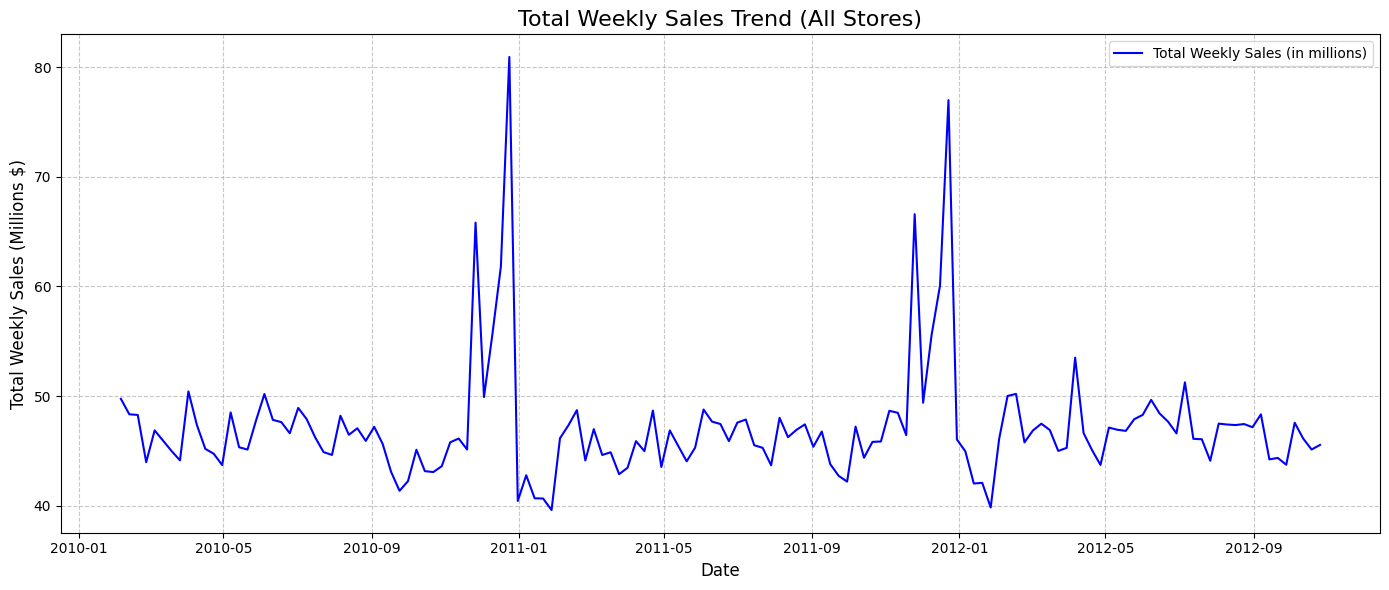


4. Performing Advanced EDA: Sales by Month and Holiday Flag...


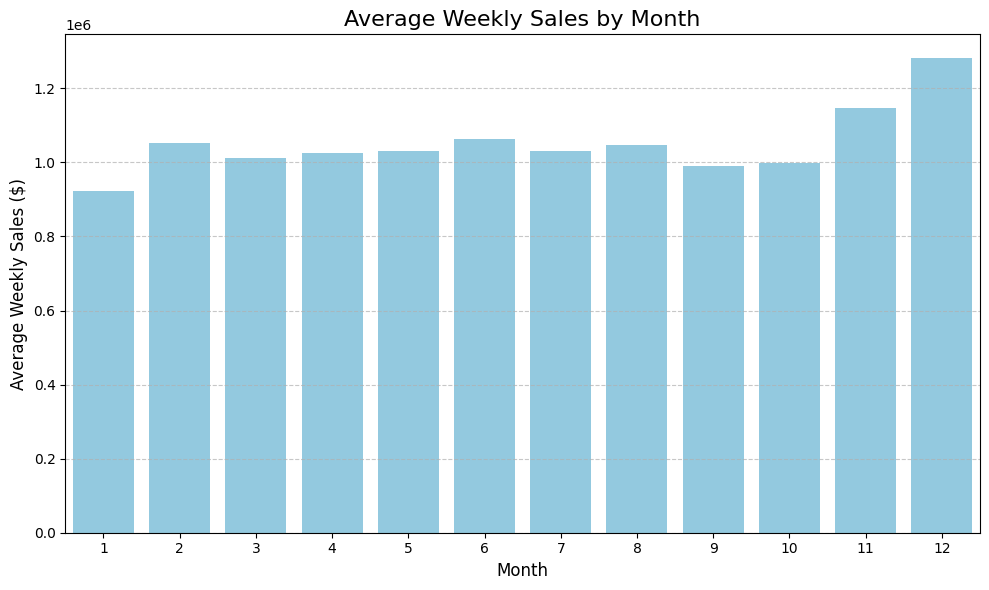

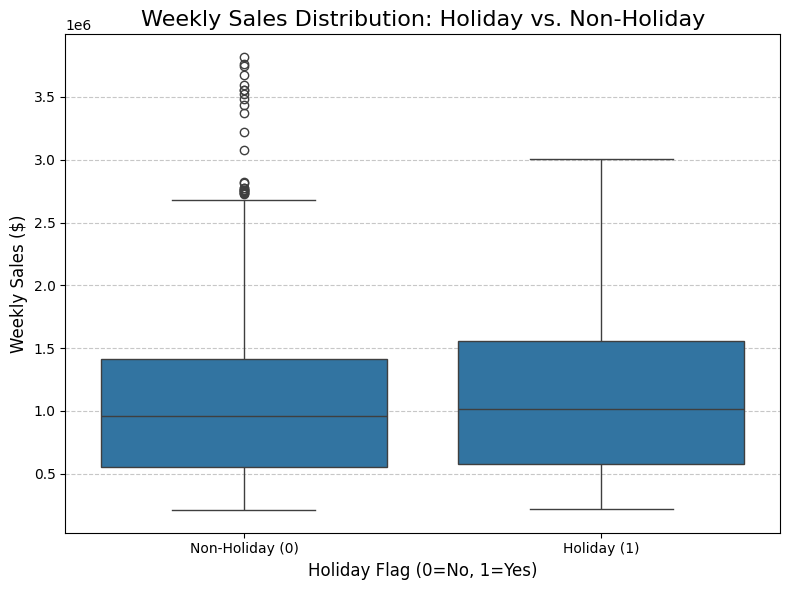


Feature Engineering complete. Prepared data saved to 'Walmart_Prepared_FE.csv'.
EDA and Feature Engineering steps completed successfully.


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. Data Loading and Initial Conversion ---
print("1. Loading Data and Date Conversion...")
df = pd.read_csv('Csv_data\Walmart.csv', low_memory=False)

# Convert 'Date' to datetime object (Essential first step)
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Create Time-Based Features (Essential for Time Series Modeling) - Added to fix KeyError
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week.astype(int)
df['DayOfWeek'] = df['Date'].dt.dayofweek

# --- 2. Exploratory Data Analysis (EDA) ---

# A. Overall Weekly Sales Trend (Basic Time Series EDA)
print("\n2. Performing EDA: Total Weekly Sales Trend...")
# Aggregate sales across all stores
weekly_sales_trend = df.groupby('Date')['Weekly_Sales'].sum().reset_index()

plt.figure(figsize=(14, 6))
plt.plot(weekly_sales_trend['Date'], weekly_sales_trend['Weekly_Sales'] / 1e6,
         label='Total Weekly Sales (in millions)', color='blue')
plt.title('Total Weekly Sales Trend (All Stores)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel(r'Total Weekly Sales (Millions $)', fontsize=12) # Fixed escape sequence
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


# --- 4. Advanced EDA (Using New Features) ---

# B. Average Weekly Sales by Month (Seasonality)
print("\n4. Performing Advanced EDA: Sales by Month and Holiday Flag...")
monthly_sales = df.groupby('Month')['Weekly_Sales'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='Month', y='Weekly_Sales', data=monthly_sales, color='skyblue')
plt.title('Average Weekly Sales by Month', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel(r'Average Weekly Sales ($)', fontsize=12) # Fixed escape sequence
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()



# C. Sales Distribution by Holiday Flag
plt.figure(figsize=(8, 6))
sns.boxplot(x='Holiday_Flag', y='Weekly_Sales', data=df)
plt.title('Weekly Sales Distribution: Holiday vs. Non-Holiday', fontsize=16)
plt.xlabel('Holiday Flag (0=No, 1=Yes)', fontsize=12)
plt.ylabel(r'Weekly Sales ($)', fontsize=12) # Fixed escape sequence
plt.xticks(ticks=[0, 1], labels=['Non-Holiday (0)', 'Holiday (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



# Final step: Save the prepared data
df.to_csv('Csv_data\Walmart_Prepared_FE.csv', index=False)
print("\nFeature Engineering complete. Prepared data saved to 'Walmart_Prepared_FE.csv'.")
print("EDA and Feature Engineering steps completed successfully.")

In [ ]:
# --- PER-STORE PROPHET FORECASTING CODE ---
# Copy and paste this into a new cell in your notebook

import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# 1. Setup Metrics
def mean_absolute_percentage_error(y_true, y_pred):
    epsilon = 1e-10 
    y_true_safe = np.where(y_true == 0, epsilon, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true_safe)) * 100

# 2. Main Loop for Per-Store Training
print("Starting Prophet forecasting for all 45 stores...")
all_metrics = []
feature_cols = ['Holiday_Flag', 'CPI', 'Unemployment']
unique_stores = df['Store'].unique()

for store_id in unique_stores:
    # Filter Data for Store
    store_df = df[df['Store'] == store_id].copy().sort_values('Date')
    
    # Prepare for Prophet
    prophet_df = store_df[['Date', 'Weekly_Sales'] + feature_cols].rename(
        columns={'Date': 'ds', 'Weekly_Sales': 'y'}
    )
    
    # Train/Test Split (80/20)
    split_idx = int(len(prophet_df) * 0.8)
    train_df = prophet_df.iloc[:split_idx]
    test_df = prophet_df.iloc[split_idx:]
    
    # Initialize and Train
    m = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
    for col in feature_cols:
        m.add_regressor(col)
        
    m.fit(train_df)
    
    # Forecast
    future = test_df[['ds'] + feature_cols]
    forecast = m.predict(future)
    
    # Evaluate
    y_true = test_df['y'].values
    y_pred = forecast['yhat'].values
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    # Store Prediction for Next Step (Simulated T+1)
    # In a real scenario, you would create a future dataframe for the next unobserved week
    prediction_t_plus_1 = y_pred[-1] 
    
    all_metrics.append({
        'Store': store_id,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'Prediction_T+1': prediction_t_plus_1
    })

# 3. Summary
metrics_df = pd.DataFrame(all_metrics)
print(f"Average MAE: ${metrics_df['MAE'].mean():,.2f}")
print(f"Average RMSE: ${metrics_df['RMSE'].mean():,.2f}")
print(f"Average MAPE: {metrics_df['MAPE'].mean():.2f}%")

# Save for A.R.E.
metrics_df.to_csv('Csv_data\prophet_per_store_metrics.csv', index=False)

16:51:19 - cmdstanpy - INFO - Chain [1] start processing
16:51:19 - cmdstanpy - INFO - Chain [1] done processing


Starting Prophet forecasting for all 45 stores...


16:51:19 - cmdstanpy - INFO - Chain [1] start processing
16:51:19 - cmdstanpy - INFO - Chain [1] done processing
16:51:19 - cmdstanpy - INFO - Chain [1] start processing
16:51:19 - cmdstanpy - INFO - Chain [1] done processing
16:51:19 - cmdstanpy - INFO - Chain [1] start processing
16:51:19 - cmdstanpy - INFO - Chain [1] done processing
16:51:20 - cmdstanpy - INFO - Chain [1] start processing
16:51:20 - cmdstanpy - INFO - Chain [1] done processing
16:51:20 - cmdstanpy - INFO - Chain [1] start processing
16:51:20 - cmdstanpy - INFO - Chain [1] done processing
16:51:20 - cmdstanpy - INFO - Chain [1] start processing
16:51:20 - cmdstanpy - INFO - Chain [1] done processing
16:51:20 - cmdstanpy - INFO - Chain [1] start processing
16:51:20 - cmdstanpy - INFO - Chain [1] done processing
16:51:20 - cmdstanpy - INFO - Chain [1] start processing
16:51:21 - cmdstanpy - INFO - Chain [1] done processing
16:51:21 - cmdstanpy - INFO - Chain [1] start processing
16:51:21 - cmdstanpy - INFO - Chain [1]

Average MAE: $62,662.67
Average RMSE: $73,976.62
Average MAPE: 6.26%


In [5]:
from prophet import Prophet
# --- CONFIGURATION ---
TARGET_STORE_ID = 1  # Change this to analyze a different store
TRAIN_SPLIT_RATIO = 0.8

# 1. Load Data
# Ensure you are using the feature-engineered dataset
df = pd.read_csv('Csv_data\Walmart_Prepared_FE.csv')
df['Date'] = pd.to_datetime(df['Date'])

# 2. Filter for Target Store
store_df = df[df['Store'] == TARGET_STORE_ID].copy().sort_values('Date')

# 3. Prepare Data for Prophet
# Prophet requires columns named 'ds' (Date) and 'y' (Target)
prophet_df = store_df[['Date', 'Weekly_Sales', 'Holiday_Flag', 'CPI', 'Unemployment']].rename(
    columns={'Date': 'ds', 'Weekly_Sales': 'y'}
)

# 4. Train/Test Split
split_idx = int(len(prophet_df) * TRAIN_SPLIT_RATIO)
train_df = prophet_df.iloc[:split_idx]
test_df = prophet_df.iloc[split_idx:]

print(f"Training Prophet Model for Store {TARGET_STORE_ID}...")
print(f"Train samples: {len(train_df)}, Test samples: {len(test_df)}")

# 5. Initialize and Train Model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    interval_width=0.95
)

# Add Regressors (External Features)
model.add_regressor('Holiday_Flag')
model.add_regressor('CPI')
model.add_regressor('Unemployment')

model.fit(train_df)

# 6. Make Predictions
# We predict on the test set timeframe
future = test_df[['ds', 'Holiday_Flag', 'CPI', 'Unemployment']]
forecast = model.predict(future)

# 7. Calculate Evaluation Metrics
y_true = test_df['y'].values
y_pred = forecast['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# MAPE Function (handling division by zero)
epsilon = 1e-10
y_true_safe = np.where(y_true == 0, epsilon, y_true)
mape = np.mean(np.abs((y_true - y_pred) / y_true_safe)) * 100

print(f"\n--- Evaluation Metrics for Store {TARGET_STORE_ID} ---")
print(f"MAE:  ${mae:,.2f}")
print(f"RMSE: ${rmse:,.2f}")
print(f"MAPE: {mape:.2f}%")

# 8. Visualize Predicted vs Actual
plt.figure(figsize=(15, 7))
plt.plot(train_df['ds'], train_df['y'], label='Training Data', color='gray', alpha=0.6)
plt.plot(test_df['ds'], y_true, label='Actual Sales (Test)', color='blue', linewidth=2)
plt.plot(test_df['ds'], y_pred, label='Prophet Forecast', color='red', linestyle='--', linewidth=2)

# Optional: Plot confidence intervals
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='red', alpha=0.1, label='Confidence Interval')

plt.title(f'Store {TARGET_STORE_ID}: Actual vs. Prophet Forecast', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Weekly Sales ($)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

d:\project\DT Project\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
17:35:01 - cmdstanpy - INFO - Chain [1] start processing


Training Prophet Model for Store 1...
Train samples: 114, Test samples: 29


17:35:01 - cmdstanpy - INFO - Chain [1] done processing


NameError: name 'mean_absolute_error' is not defined

In [8]:
import pandas as pd
import numpy as np
import pickle
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Input, LSTM, Dense

# --- CONFIGURATION ---
INPUT_FILE = 'Csv_data\Walmart_Prepared_FE.csv'
TIME_STEP = 20
BASE_MODEL_DIR = 'store_models'
OUTPUT_SUMMARY_FILE = 'Csv_data\lstm_forecasts_and_metrics.csv' # <--- NEW: Output for replenishment

if not os.path.exists(BASE_MODEL_DIR):
    os.makedirs(BASE_MODEL_DIR)

REQUIRED_FEATURES = ['Weekly_Sales', 'Holiday_Flag', 'Sales_Lag_1', 'Sales_Lag_2', 'Sales_Lag_4', 'Sales_Lag_52', 'Sales_Rolling_Mean_4']
MODEL_INPUT_COLS = ['Weekly_Sales', 'Holiday_Flag', 'Sales_Lag_1', 'Sales_Rolling_Mean_4']

# --- HELPER FUNCTIONS ---

def create_sequences(data, time_step, num_features):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :num_features])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

def build_and_train_lstm(X_train, y_train, time_step, num_features):
    input_layer = Input(shape=(time_step, num_features))
    x = LSTM(100, return_sequences=True)(input_layer)
    x = Dropout(0.1)(x)
    x = LSTM(100, return_sequences=False)(x)
    x = Dropout(0.1)(x)
    output_layer = Dense(1)(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Reduced epochs for speed in demonstration (increase for final)
    model.fit(X_train, y_train, batch_size=1, epochs=50, verbose=0) 
    return model

def check_and_save_best_model(store_id, model, scaler, current_mae):
    store_dir = os.path.join(BASE_MODEL_DIR, f'store_{store_id}')
    if not os.path.exists(store_dir):
        os.makedirs(store_dir)

    mae_file_path = os.path.join(store_dir, f'best_mae_store_{store_id}.txt')
    model_path = os.path.join(store_dir, f'lstm_model_store_{store_id}.h5')
    scaler_path = os.path.join(store_dir, f'scaler_store_{store_id}.pkl')
    
    save_model = False
    
    if os.path.exists(mae_file_path):
        with open(mae_file_path, 'r') as f:
            try:
                previous_best_mae = float(f.read())
                if current_mae < previous_best_mae:
                    print(f"   [Store {store_id}] ✅ IMPROVEMENT! MAE: {current_mae:.0f} < {previous_best_mae:.0f}")
                    save_model = True
            except ValueError:
                save_model = True
    else:
        print(f"   [Store {store_id}] 🆕 First run. MAE: {current_mae:.0f}")
        save_model = True
        
    if save_model:
        model.save(model_path)
        with open(scaler_path, 'wb') as file:
            pickle.dump(scaler, file)
        with open(mae_file_path, 'w') as f:
            f.write(str(current_mae))
        return True
    return False

# --- MAIN EXECUTION ---

# 1. Load Data
print(f"Loading data from {INPUT_FILE}...")
if not os.path.exists(INPUT_FILE):
    # Fallback generation
    if os.path.exists('Walmart.csv'):
        print(f"⚠️ Generating {INPUT_FILE}...")
        df = pd.read_csv('Walmart.csv', low_memory=False)
        df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
        df['Year'] = df['Date'].dt.year
        df['Month'] = df['Date'].dt.month
        df['Week'] = df['Date'].dt.isocalendar().week.astype(int)
        df['DayOfWeek'] = df['Date'].dt.dayofweek
        df.to_csv(INPUT_FILE, index=False)
    else:
        raise FileNotFoundError(f"Missing input file.")

df = pd.read_csv(INPUT_FILE)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by=['Store', 'Date'], inplace=True)

# 2. Feature Engineering
missing_features = [col for col in REQUIRED_FEATURES if col not in df.columns]
if missing_features:
    print(f"⚠️ Features missing. Generating...")
    lags = [1, 2, 4, 52]
    for lag in lags:
        col_name = f'Sales_Lag_{lag}'
        if col_name not in df.columns:
            df[col_name] = df.groupby('Store')['Weekly_Sales'].shift(lag)

    window_size = 4
    if f'Sales_Rolling_Mean_{window_size}' not in df.columns:
        df[f'Sales_Rolling_Mean_{window_size}'] = df.groupby('Store')['Weekly_Sales'].transform(
            lambda x: x.shift(1).rolling(window=window_size).mean()
        )
    df.fillna(0, inplace=True)

    # --- NEW CODE: SAVE UPDATED FEATURES ---
    print(f"💾 Saving engineered features as Walmart_Final_FE.csv for future use...")
    df.to_csv('Csv_data\Walmart_Final_FE.csv', index=False)
else:
    print("✅ Features ready.")

# 3. Training Loop
print(f"\nStarting Per-Store Training...")

unique_stores = df['Store'].unique()
num_features = len(MODEL_INPUT_COLS)
forecast_results = []

for store_id in unique_stores:
    print(f"Processing Store {store_id}...", end="\r")
    
    # A. Prepare Data
    store_data = df[df['Store'] == store_id].copy()
    data_values = store_data[MODEL_INPUT_COLS].values
    
    # B. Scale
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data_values)
    
    # C. Sequence
    X, y = create_sequences(scaled_data, TIME_STEP, num_features)
    
    # D. Split
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    
    if len(X_train) == 0: continue

    # E. Train
    model = build_and_train_lstm(X_train, y_train, TIME_STEP, num_features)
    
    # F. Evaluate
    preds_scaled = model.predict(X_test, verbose=0)
    
    # Inverse Transform Predictions
    dummy_pred = np.zeros((len(preds_scaled), num_features))
    dummy_pred[:, 0] = preds_scaled[:, 0]
    preds_actual = scaler.inverse_transform(dummy_pred)[:, 0]
    
    # Inverse Transform Actuals
    dummy_test = np.zeros((len(y_test), num_features))
    dummy_test[:, 0] = y_test
    y_actual = scaler.inverse_transform(dummy_test)[:, 0]
    
    mae = mean_absolute_error(y_actual, preds_actual)
    
    # G. GENERATE T+1 FORECAST (The Missing Piece)
    # Use the LAST available sequence (most recent 20 weeks) to predict the future
    last_sequence_scaled = scaled_data[-TIME_STEP:] # Shape (20, 4)
    last_sequence_reshaped = last_sequence_scaled.reshape(1, TIME_STEP, num_features)
    
    future_pred_scaled = model.predict(last_sequence_reshaped, verbose=0)
    
    # Inverse transform future prediction
    dummy_future = np.zeros((1, num_features))
    dummy_future[:, 0] = future_pred_scaled[0, 0]
    forecast_t_plus_1 = scaler.inverse_transform(dummy_future)[0, 0]

    # H. Save & Store Results
    check_and_save_best_model(store_id, model, scaler, mae)
    
    forecast_results.append({
        'Store': store_id,
        'LSTM_MAE': round(mae, 2),
        'Forecast_T_plus_1': round(forecast_t_plus_1, 2)
    })

# --- SAVE SUMMARY CSV ---
results_df = pd.DataFrame(forecast_results)
results_df.to_csv(OUTPUT_SUMMARY_FILE, index=False)

print(f"\n\n✅ DONE! Results saved to '{OUTPUT_SUMMARY_FILE}'")
print(results_df.head().to_string())

Loading data from Csv_data\Walmart_Prepared_FE.csv...
⚠️ Features missing. Generating...
💾 Saving engineered features as Walmart_Final_FE.csv for future use...

Starting Per-Store Training...


KeyboardInterrupt: 

In [9]:
import pandas as pd
import numpy as np
import os
import pickle
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- 1. CONFIGURATION ---
INPUT_FILE = 'Csv_data\Walmart_Final_FE.csv'
MODEL_BASE_DIR = 'store_models'
TIME_STEP = 20
MODEL_INPUT_COLS = ['Weekly_Sales', 'Holiday_Flag', 'Sales_Lag_1', 'Sales_Rolling_Mean_4']

# --- 2. HELPER FUNCTIONS ---

def create_sequences(data, time_step):
    """Generates sequences for LSTM (X) and target (y)."""
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :]) 
        y.append(data[i + time_step, 0])     
    return np.array(X), np.array(y)

def calculate_mape(y_true, y_pred):
    epsilon = 1e-10 
    y_true_safe = np.where(y_true == 0, epsilon, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true_safe)) * 100

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# --- 3. MAIN EVALUATION LOOP ---

print("Loading data...")
if not os.path.exists(INPUT_FILE):
    raise FileNotFoundError(f"{INPUT_FILE} not found. Run the training script first.")

df = pd.read_csv(INPUT_FILE)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by=['Store', 'Date'], inplace=True)

unique_stores = df['Store'].unique()
all_store_metrics = []

print(f"\nStarting Evaluation for {len(unique_stores)} Stores...")
print(f"Reading models from: {MODEL_BASE_DIR}/")

for store_id in unique_stores:
    # 1. Paths
    store_dir = os.path.join(MODEL_BASE_DIR, f'store_{store_id}')
    model_path = os.path.join(store_dir, f'lstm_model_store_{store_id}.h5')
    scaler_path = os.path.join(store_dir, f'scaler_store_{store_id}.pkl')
    
    # 2. Check if model exists
    if not os.path.exists(model_path) or not os.path.exists(scaler_path):
        print(f"⚠️ Artifacts missing for Store {store_id}. Skipping.")
        continue
        
    # 3. Load Artifacts
    try:
        model = load_model(model_path)
        with open(scaler_path, 'rb') as f:
            scaler = pickle.load(f)
    except Exception as e:
        print(f"❌ Error loading Store {store_id}: {e}")
        continue

    # 4. Prepare Data
    store_data = df[df['Store'] == store_id].copy()
    data_values = store_data[MODEL_INPUT_COLS].values
    
    # Scale
    scaled_data = scaler.fit_transform(data_values)
    
    # Sequence & Split (Test Set)
    X, y = create_sequences(scaled_data, TIME_STEP)
    split_idx = int(len(X) * 0.8)
    X_test = X[split_idx:]
    y_test = y[split_idx:]
    
    if len(X_test) == 0: continue

    # 5. Evaluation Predictions
    preds_scaled = model.predict(X_test, verbose=0)
    
    # Inverse Transform
    num_features = len(MODEL_INPUT_COLS)
    dummy_pred = np.zeros((len(preds_scaled), num_features))
    dummy_pred[:, 0] = preds_scaled[:, 0]
    preds_actual = scaler.inverse_transform(dummy_pred)[:, 0]
    
    dummy_test = np.zeros((len(y_test), num_features))
    dummy_test[:, 0] = y_test
    y_actual = scaler.inverse_transform(dummy_test)[:, 0]
    
    # Calculate Metrics
    mae = mean_absolute_error(y_actual, preds_actual)
    rmse = calculate_rmse(y_actual, preds_actual)
    mape = calculate_mape(y_actual, preds_actual)
    
    # --- 6. GENERATE FUTURE T+1 FORECAST ---
    # Use the VERY LAST sequence available (most recent 20 weeks)
    last_sequence_scaled = scaled_data[-TIME_STEP:] # Shape (20, 4)
    last_sequence_reshaped = last_sequence_scaled.reshape(1, TIME_STEP, num_features)
    
    future_pred_scaled = model.predict(last_sequence_reshaped, verbose=0)
    
    # Inverse Transform Future Prediction
    dummy_future = np.zeros((1, num_features))
    dummy_future[:, 0] = future_pred_scaled[0, 0]
    forecast_t_plus_1 = scaler.inverse_transform(dummy_future)[0, 0]
    
    # Store everything
    all_store_metrics.append({
        'Store': store_id,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'Prediction_T+1': forecast_t_plus_1
    })
    
    print(f"   Store {store_id}: MAE=${mae:,.0f} | MAPE={mape:.2f}% | Forecast=${forecast_t_plus_1:,.0f}")

# --- 7. SUMMARY REPORT ---

metrics_df = pd.DataFrame(all_store_metrics)

print("\n" + "="*40)
print("       LSTM MODEL PERFORMANCE SUMMARY       ")
print("="*40)
print(f"Total Stores Evaluated: {len(metrics_df)}")
print(f"Average MAE:  ${metrics_df['MAE'].mean():,.2f}")
print(f"Average RMSE: ${metrics_df['RMSE'].mean():,.2f}")
print(f"Average MAPE: {metrics_df['MAPE'].mean():.2f}%")
print("="*40)

# Save results including T+1 prediction
metrics_df.to_csv('Csv_data\lstm_per_store_evaluation_metrics.csv', index=False)
print("\nDetailed metrics saved to 'lstm_per_store_evaluation_metrics.csv'")

Loading data...

Starting Evaluation for 45 Stores...
Reading models from: store_models/


   Store 1: MAE=$62,339 | MAPE=3.90% | Forecast=$1,582,730


   Store 2: MAE=$51,040 | MAPE=2.68% | Forecast=$1,881,840


   Store 3: MAE=$20,263 | MAPE=4.82% | Forecast=$408,913


   Store 4: MAE=$58,613 | MAPE=2.75% | Forecast=$2,253,497


   Store 5: MAE=$15,091 | MAPE=4.54% | Forecast=$333,957


   Store 6: MAE=$64,289 | MAPE=3.97% | Forecast=$1,495,100


   Store 7: MAE=$38,595 | MAPE=6.10% | Forecast=$495,120


   Store 8: MAE=$43,164 | MAPE=4.71% | Forecast=$928,498


   Store 9: MAE=$21,972 | MAPE=3.99% | Forecast=$568,298


   Store 10: MAE=$47,137 | MAPE=2.65% | Forecast=$1,794,058


   Store 11: MAE=$58,023 | MAPE=4.32% | Forecast=$1,331,160


   Store 12: MAE=$36,377 | MAPE=3.60% | Forecast=$1,015,191


   Store 13: MAE=$92,059 | MAPE=4.43% | Forecast=$1,915,525


   Store 14: MAE=$215,697 | MAPE=13.28% | Forecast=$1,954,189


   Store 15: MAE=$32,279 | MAPE=5.43% | Forecast=$631,450


   Store 16: MAE=$24,025 | MAPE=4.39% | Forecast=$449,086


   Store 17: MAE=$65,433 | MAPE=6.51% | Forecast=$960,683


   Store 18: MAE=$46,801 | MAPE=4.41% | Forecast=$1,029,062


   Store 19: MAE=$57,758 | MAPE=4.21% | Forecast=$1,411,832


   Store 20: MAE=$89,883 | MAPE=4.25% | Forecast=$2,046,890


   Store 21: MAE=$49,049 | MAPE=7.32% | Forecast=$757,036


   Store 22: MAE=$32,385 | MAPE=3.19% | Forecast=$1,045,287


   Store 23: MAE=$70,078 | MAPE=4.72% | Forecast=$1,363,193


   Store 24: MAE=$62,385 | MAPE=4.34% | Forecast=$1,301,193


   Store 25: MAE=$27,727 | MAPE=3.88% | Forecast=$698,868


   Store 26: MAE=$32,982 | MAPE=3.13% | Forecast=$976,155


   Store 27: MAE=$66,957 | MAPE=3.88% | Forecast=$1,734,214


   Store 28: MAE=$47,266 | MAPE=3.84% | Forecast=$1,459,004


   Store 29: MAE=$28,635 | MAPE=5.44% | Forecast=$537,437


   Store 30: MAE=$7,456 | MAPE=1.71% | Forecast=$435,187


   Store 31: MAE=$23,538 | MAPE=1.71% | Forecast=$1,398,564


   Store 32: MAE=$34,981 | MAPE=2.92% | Forecast=$1,156,238


   Store 33: MAE=$7,926 | MAPE=2.96% | Forecast=$247,104


   Store 34: MAE=$30,744 | MAPE=3.17% | Forecast=$954,797


   Store 35: MAE=$60,509 | MAPE=6.80% | Forecast=$784,777


   Store 36: MAE=$10,912 | MAPE=3.56% | Forecast=$274,169


   Store 37: MAE=$10,940 | MAPE=2.11% | Forecast=$529,543


   Store 38: MAE=$22,474 | MAPE=5.20% | Forecast=$420,777


   Store 39: MAE=$78,841 | MAPE=4.92% | Forecast=$1,506,956


   Store 40: MAE=$43,928 | MAPE=4.30% | Forecast=$979,238


   Store 41: MAE=$56,182 | MAPE=3.92% | Forecast=$1,343,803


   Store 42: MAE=$13,718 | MAPE=2.41% | Forecast=$553,130


   Store 43: MAE=$15,503 | MAPE=2.50% | Forecast=$612,654


   Store 44: MAE=$9,330 | MAPE=2.73% | Forecast=$332,435
   Store 45: MAE=$25,883 | MAPE=3.32% | Forecast=$755,839

       LSTM MODEL PERFORMANCE SUMMARY       
Total Stores Evaluated: 45
Average MAE:  $44,692.56
Average RMSE: $56,112.49
Average MAPE: 4.20%

Detailed metrics saved to 'lstm_per_store_evaluation_metrics.csv'


Loading data for Store 1...
Loading model and scaler...
Generating predictions...
Plotting results for Store 1...


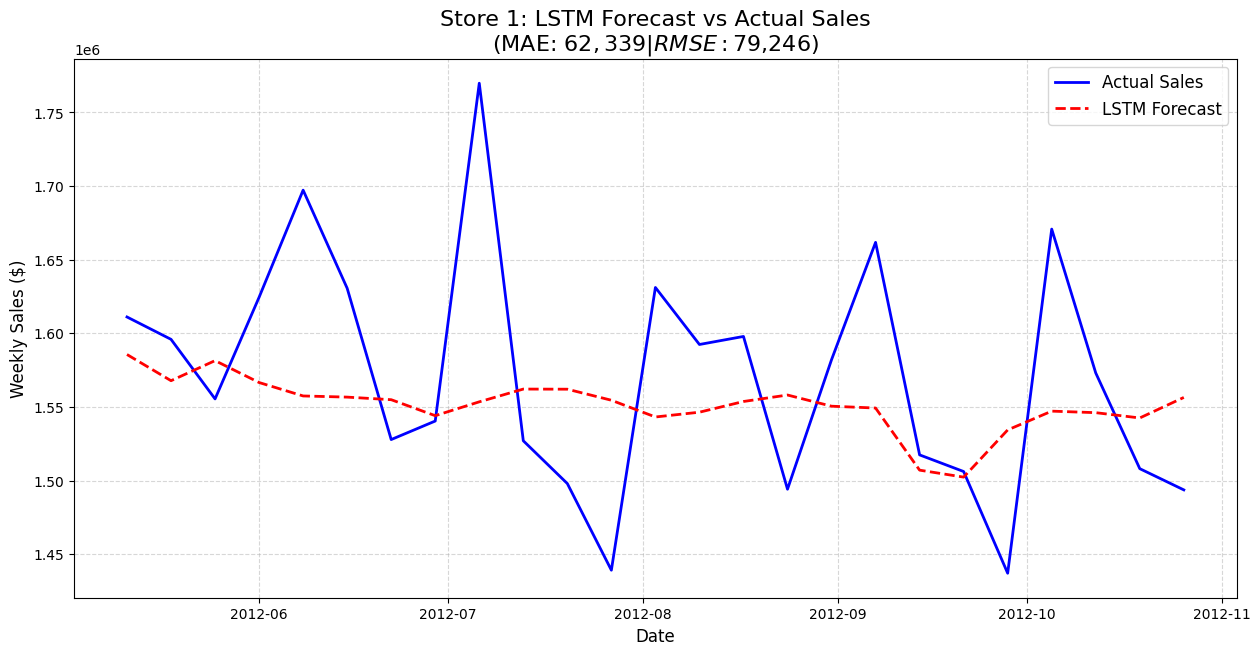

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- 1. CONFIGURATION ---
TARGET_STORE_ID = 1  # Change this to visualize different stores
INPUT_FILE = 'Csv_data\Walmart_Final_FE.csv'
MODEL_BASE_DIR = 'store_models'
TIME_STEP = 20
MODEL_INPUT_COLS = ['Weekly_Sales', 'Holiday_Flag', 'Sales_Lag_1', 'Sales_Rolling_Mean_4']

# --- 2. HELPER FUNCTIONS ---

def create_sequences(data, time_step):
    """Generates sequences for LSTM (X) and target (y)."""
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :]) 
        y.append(data[i + time_step, 0])     
    return np.array(X), np.array(y)

# --- 3. MAIN VISUALIZATION LOGIC ---

print(f"Loading data for Store {TARGET_STORE_ID}...")
if not os.path.exists(INPUT_FILE):
    raise FileNotFoundError(f"{INPUT_FILE} not found. Run the training script first.")

# A. Load and Filter Data
df = pd.read_csv(INPUT_FILE)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by=['Store', 'Date'], inplace=True)

store_df = df[df['Store'] == TARGET_STORE_ID].copy()
store_dates = store_df['Date'].values

# B. Load Model & Scaler
store_dir = os.path.join(MODEL_BASE_DIR, f'store_{TARGET_STORE_ID}')
model_path = os.path.join(store_dir, f'lstm_model_store_{TARGET_STORE_ID}.h5')
scaler_path = os.path.join(store_dir, f'scaler_store_{TARGET_STORE_ID}.pkl')

if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model for Store {TARGET_STORE_ID} not found in {store_dir}")

print("Loading model and scaler...")
model = load_model(model_path)
with open(scaler_path, 'rb') as f:
    scaler = pickle.load(f)

# C. Prepare Sequences
data_values = store_df[MODEL_INPUT_COLS].values
scaled_data = scaler.fit_transform(data_values)
X, y = create_sequences(scaled_data, TIME_STEP)

# D. Split (Visualize Test Set)
split_idx = int(len(X) * 0.8)
X_test = X[split_idx:]
y_test = y[split_idx:]

# Get corresponding dates for the test set
# The test set starts after 'split_idx' + 'TIME_STEP' offset
test_dates = store_dates[split_idx + TIME_STEP:]

# E. Predict
print("Generating predictions...")
preds_scaled = model.predict(X_test, verbose=0)

# F. Inverse Transform
# Create dummy arrays to inverse transform (since scaler expects 4 features)
num_features = len(MODEL_INPUT_COLS)

# Inverse Preds
dummy_pred = np.zeros((len(preds_scaled), num_features))
dummy_pred[:, 0] = preds_scaled[:, 0]
preds_actual = scaler.inverse_transform(dummy_pred)[:, 0]

# Inverse Actuals
dummy_test = np.zeros((len(y_test), num_features))
dummy_test[:, 0] = y_test
y_actual = scaler.inverse_transform(dummy_test)[:, 0]

# G. Calculate Metrics for Title
mae = mean_absolute_error(y_actual, preds_actual)
rmse = np.sqrt(mean_squared_error(y_actual, preds_actual))

# --- 4. PLOTTING ---

print(f"Plotting results for Store {TARGET_STORE_ID}...")

plt.figure(figsize=(15, 7))
plt.plot(test_dates, y_actual, label='Actual Sales', color='blue', linewidth=2)
plt.plot(test_dates, preds_actual, label='LSTM Forecast', color='red', linestyle='--', linewidth=2)

plt.title(f'Store {TARGET_STORE_ID}: LSTM Forecast vs Actual Sales\n(MAE: ${mae:,.0f} | RMSE: ${rmse:,.0f})', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Weekly Sales ($)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Loading metrics...

       🏆 MODEL PERFORMANCE SHOWDOWN 🏆       
Total Stores Compared: 45
LSTM Wins:             34 / 45 (75.6%)
--------------------------------------------------
Avg Baseline MAE:      $62,662.67
Avg LSTM MAE:          $44,692.56
Overall Improvement:   $17,970.11 (28.7%)
✅ Saved comparison chart to 'mae_comparison_chart.png'


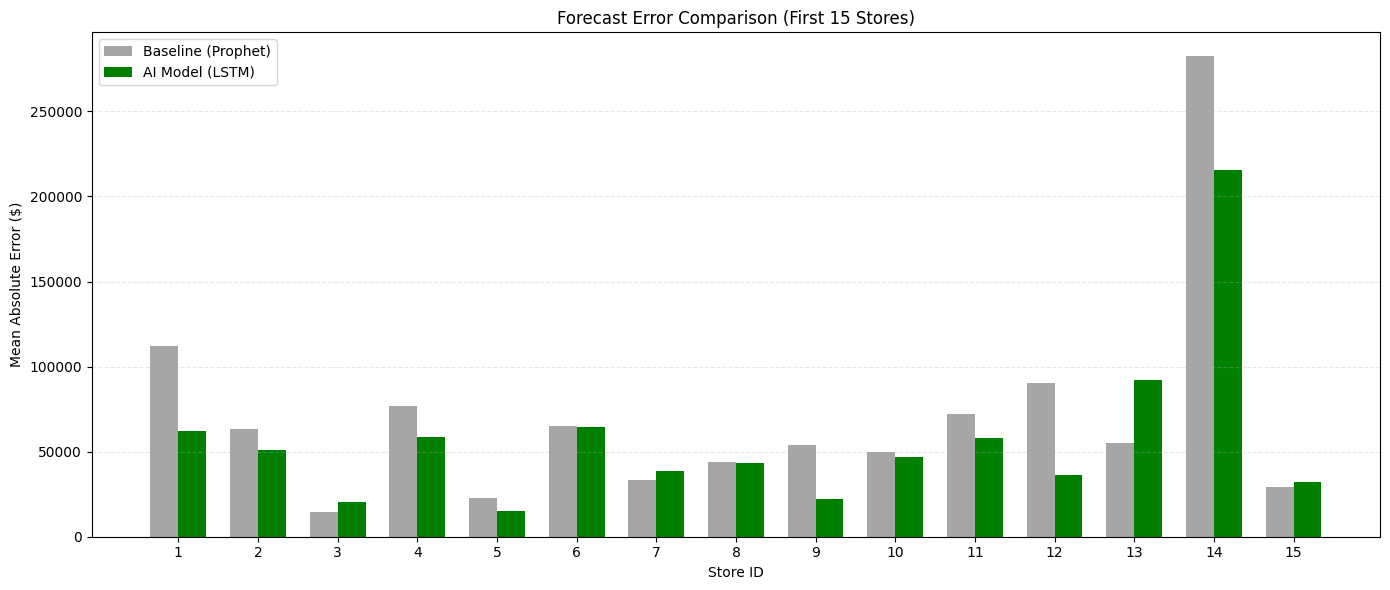

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# --- CONFIGURATION ---
BASELINE_FILE = 'Csv_data\prophet_per_store_metrics.csv'
LSTM_FILE = 'Csv_data\lstm_per_store_evaluation_metrics.csv'

# --- 1. LOAD DATA ---
print("Loading metrics...")
if not os.path.exists(BASELINE_FILE) or not os.path.exists(LSTM_FILE):
    raise FileNotFoundError("Missing metrics files. Run baseline and LSTM evaluation scripts first.")

df_base = pd.read_csv(BASELINE_FILE)
df_lstm = pd.read_csv(LSTM_FILE)

# --- 2. MERGE AND COMPARE ---
# Rename columns for clarity before merging
df_base = df_base[['Store', 'MAE', 'MAPE']].rename(columns={'MAE': 'Baseline_MAE', 'MAPE': 'Baseline_MAPE'})
df_lstm = df_lstm[['Store', 'MAE', 'MAPE']].rename(columns={'MAE': 'LSTM_MAE', 'MAPE': 'LSTM_MAPE'})

comparison_df = pd.merge(df_base, df_lstm, on='Store')

# Calculate Improvement
# Positive Improvement means LSTM error is LOWER than Baseline error
comparison_df['MAE_Improvement'] = comparison_df['Baseline_MAE'] - comparison_df['LSTM_MAE']
comparison_df['MAE_Improvement_Pct'] = (comparison_df['MAE_Improvement'] / comparison_df['Baseline_MAE']) * 100

# Identify Winner
comparison_df['Winner'] = np.where(comparison_df['LSTM_MAE'] < comparison_df['Baseline_MAE'], 'LSTM', 'Baseline')

# --- 3. GENERATE SUMMARY REPORT ---
avg_base_mae = comparison_df['Baseline_MAE'].mean()
avg_lstm_mae = comparison_df['LSTM_MAE'].mean()
lstm_wins = len(comparison_df[comparison_df['Winner'] == 'LSTM'])
total_stores = len(comparison_df)

print("\n" + "="*50)
print("       🏆 MODEL PERFORMANCE SHOWDOWN 🏆       ")
print("="*50)
print(f"Total Stores Compared: {total_stores}")
print(f"LSTM Wins:             {lstm_wins} / {total_stores} ({lstm_wins/total_stores:.1%})")
print("-" * 50)
print(f"Avg Baseline MAE:      ${avg_base_mae:,.2f}")
print(f"Avg LSTM MAE:          ${avg_lstm_mae:,.2f}")
print(f"Overall Improvement:   ${(avg_base_mae - avg_lstm_mae):,.2f} ({((avg_base_mae - avg_lstm_mae)/avg_base_mae)*100:.1f}%)")
print("="*50)



# --- 4. VISUALIZATION ---

# A. Bar Chart: MAE Comparison for First 10 Stores (for readability)
sample_n = 15
subset = comparison_df.head(sample_n)
x = np.arange(len(subset))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 6))
rects1 = ax.bar(x - width/2, subset['Baseline_MAE'], width, label='Baseline (Prophet)', color='gray', alpha=0.7)
rects2 = ax.bar(x + width/2, subset['LSTM_MAE'], width, label='AI Model (LSTM)', color='green')

ax.set_ylabel('Mean Absolute Error ($)')
ax.set_title(f'Forecast Error Comparison (First {sample_n} Stores)')
ax.set_xticks(x)
ax.set_xticklabels(subset['Store'])
ax.set_xlabel('Store ID')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
print("✅ Saved comparison chart to 'mae_comparison_chart.png'")
plt.show()



In [14]:
import pandas as pd
import numpy as np

# --- CONFIGURATION ---
INPUT_FILE = 'Csv_data\Walmart_Final_FE.csv'
OUTPUT_POLICY_FILE = 'Csv_data\store_inventory_policies.csv'

# Inventory Constants (from Reference Notebook)
LEAD_TIME = 2       # Weeks
Z_SCORE = 1.65      # 95% Service Level
HOLDING_COST = 0.25 # Annual

print(f"Loading history from {INPUT_FILE}...")
df = pd.read_csv(INPUT_FILE)

# 1. Calculate Store Statistics
print("Calculating Safety Stock and EOQ for all stores...")
policy_stats = df.groupby('Store')['Weekly_Sales'].agg(['mean', 'std']).reset_index()
policy_stats.rename(columns={'mean': 'Mean_Weekly_Revenue', 'std': 'Std_Weekly_Revenue'}, inplace=True)

# 2. Apply Replenishment Logic
# Safety Stock = Z * StdDev * sqrt(LeadTime)
policy_stats['SS_Revenue'] = Z_SCORE * policy_stats['Std_Weekly_Revenue'] * np.sqrt(LEAD_TIME)

# EOQ (Simplified Revenue Version) = Mean * 3 weeks buffer
policy_stats['EOQ_Revenue'] = policy_stats['Mean_Weekly_Revenue'] * 3

# 3. Save to CSV
final_policy_df = policy_stats[['Store', 'Mean_Weekly_Revenue', 'SS_Revenue', 'EOQ_Revenue']]
final_policy_df.to_csv(OUTPUT_POLICY_FILE, index=False)

print(f"✅ Policy database created: {OUTPUT_POLICY_FILE}")
print(final_policy_df.head())

Loading history from Csv_data\Walmart_Final_FE.csv...
Calculating Safety Stock and EOQ for all stores...
✅ Policy database created: Csv_data\store_inventory_policies.csv
   Store  Mean_Weekly_Revenue     SS_Revenue   EOQ_Revenue
0      1         1.555264e+06  363973.693441  4.665793e+06
1      2         1.925751e+06  554623.582547  5.777254e+06
2      3         4.027044e+05  108084.654401  1.208113e+06
3      4         2.094713e+06  621168.388532  6.284139e+06
4      5         3.180118e+05   88059.745905  9.540354e+05
